#Hypothesis and Inference

The *science* part of data science frequently involves forming and testing hypotheses about our data and the processes that generate it.

###Statistical Hypothesis Testing

We will want to test wether a certain hypothesis is true i.e. "This coin is fair"

* In the classical setup we have a null hypothesis $H_{0}$ that represents som default position and some alternative hypothesis $H_{1}$ that we would like to compare it with
    * We will use statistics to decide whether we can reject $H_{0}$ as false or not

###Example: Flipping a Coin

Lets say we have a coin, and we want to test whether it's fair. We'll make the assumption that the coin has some probability *p* of landing heads

* Our null hypothesis is that the coin is fair, p = 0.5, and we will test this against and alternative hypothesis p ≠ 0.5
    * $H_{0}$:  p = 0.5
    * $H_{1}$:  p ≠ 0.5 

* Our test will involve flipping the coin some number *n* times and conting the number of heads *X*. Each coin flip is a Bernoulli trial, which means that *X* is a Binomial(n,p) random variable, which we can aprroximate using the normal distribution:

In [1]:
def normal_approximation_to_binomial(n,p):
    """finds mu and sigma corresponding to a Binomial(n,p)"""
    mu = n * p
    sigma = math.sqrt(p * (1 - p) * n)
    return mu, sigma

Whenever a random variable follows a normal distribution, we can use normal_cdf to figure our the probability that its realized value lies within(or outside) a particutlar interval:

In [3]:
import math

In [4]:
def normal_cdf(x, mu=0, sigma=1):
    return (1 + math.erf((x - mu) /  math.sqrt(2) / sigma)) / 2 

In [5]:
# the normal cdf is the probability the variable is below a threshold
normal_probability_below = normal_cdf

In [7]:
# it's above the threshold if it's not below
def normal_probability_above(lo, mu=0, sigma=1):
    return 1 - normal_cdf(lo, mu, sigma)  #everything always equals one

In [10]:
# it's between if it's less than hi, but not less than lo
def normal_probability_between(lo, hi, mu=0, sigma=1):
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

In [11]:
# it's outside if it's not between
def normal_probability_outside(lo, hi, mu=0, sigma=1):
    return 1 - normal_probability_between(lo, hi, mu, sigma)

* We can also do the reverse -- find either the nontail region or the (symmetric) interval around the mean that accounts for a certain level of liklihood
    * i.e. If we want to find an interval centered at the mean and containing 60% probability, then we find the cutoffs where the upper and lower tails each contain 20% fo the probability (leaving 60%)

In [12]:
# we will need inverse_normal_cdf from the previous chapter
def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    """find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    
    low_z, low_p = -10.0, 0            # normal_cdf(-10) is (very close to) 0
    hi_z,  hi_p  =  10.0, 1            # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the cdf's value there
        if mid_p < p:
            # midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p
        else:
            break

    return mid_z

In [13]:
def normal_upper_bound(probability, mu=0, sigma=1):
    """returns the z for which P(Z <= z) = probability"""
    return inverse_normal_cdf(probability, mu, sigma)

In [14]:
def normal_lower_bound(probability, mu=0, sigma=1):
    """returns the z for with P(Z >= z) = probability"""
    return inverse_normal_cdf(1 - probability, mu, sigma)

In [16]:
def normal_two_sided_bounds(probability, mu=0, sigma=1):
    """returns the symmetric (about the mean) bounds that contain the specified probability"""
    tail_probability = (1 - probability) / 2
    
    #upper bound should have tail_probability about it
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)
    
    #lower bound should have tail_probability below it
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)
    
    return lower_bound, upper_bound    
    

* In particular, let's say that we choose to flip the coin n= 1000 times. If our hypothesis of fairness is true, X should be distributed approximately normally with a mean 500 and standard deviatin 15.8

In [37]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
print(mu_0)
print(sigma_0)

500.0
15.811388300841896


* Lets graph this to make it more clear, we need normal_pdf

In [28]:
def normal_pdf(x, mu=0, sigma=1):
    sqrt_two_pi = math.sqrt(2 * math.pi)
    return (math.exp(-(x-mu)**2 / 2 / sigma ** 2) / (sqrt_two_pi * sigma))

In [29]:
from matplotlib import pyplot as plt

In [30]:
%matplotlib inline

In [46]:
xs = [x/10 for x in range(4000, 6000)]

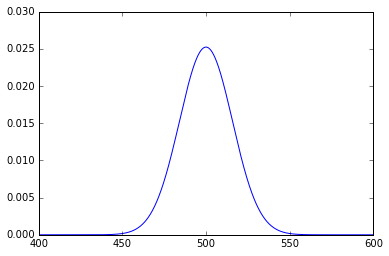

In [47]:
plt.plot(xs,[normal_pdf(x, mu_0, sigma_0) for x in xs], '-', label='mu=0,sigma=1')

* We need to make a decision about significance -- how willing we are to make a *type 1 error* (false positive), in which we reject $H_{0}$ even though it's true. For reasons unknown, this willingness is often set at 5% or 1%. We will use 5%

* Consider the test that rejects $H_{0}$ if *X* falls outside the bounds given by:

In [18]:
normal_two_sided_bounds(0.95, mu_0, sigma_0)

(469.01026640487555, 530.9897335951244)

* Assuming *p* really equals 0.5 (i.e. $H_{0}$ is true), there is just a 5% chance we observe an *X* that lies outside this interval(469 - 530), which is the exact significance we wanted. Said another way, if $H_{0}$ is true, then, approximately 19 times out of 20, this test will give the correct result. 

* We are also often interested in the **power** of a test, which is the probability of not making a *type 2 error*, in which we fail to reject $H_{0}$ even though it's false. In order to measure this, we have to specify what exactly $H_{0}$ being false *means*. (Knowing merely that p is not 0.5 doesn't give you a ton of information about the distribution of *X*.) In particular, let's check what happens if *p* is really 0.55, so that the coin is slightly biased towards heads.  

* We can calculate the power of the test with:

In [48]:
# 95% bounds based on assumption p is 0.5
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)
print(lo)
print(hi)

469.01026640487555
530.9897335951244


In [20]:
# actual mu and sigma based on p = 0.55
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)

In [22]:
# a type 2 error means we fail to reject the null hypothesis which will happen when X is still in our original interval
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1 -  type_2_probability

In [23]:
print(power)

0.8865480012953671


* Imagine instead that our null hypothesis was that the coin is not biased toward heads, or that p ≤ 0.5. In that case we want a *one-sided test* that rejects the null hypothesis when *X* is much larger than 50 but not when *X* is smaller than 50. So, a 5%- significance test involves using normal_probability_below to find the cutoff below which 95% of the probability lies:

In [24]:
hi = normal_upper_bound(0.95, mu_0, sigma_0)
print(hi)

526.0073585242053


In [26]:
type_2_probability = normal_probability_below(hi, mu_1, sigma_1)
power = 1 - type_2_probability
print(power)

0.9363794803307173


* This is a more powerful test, since it no longer rejects $H_{0}$ when *X* is below 469 (which is very unlikely to happen if $H_{1}$ is true). ===p-values

* An alternative way of thinking about the preceeding test involves *p-values*. Instead of choosing bounds based on some probability cutoff, we compute the probability -- assuming $H_{0}$ is true -- that we would see a value at least as extreme as the one we actually observed. 

* For our two-sided test of whether the coin is fair, we compute:

In [49]:
def two_sided_p_value(x, mu=0, sigma=1):
    if x >= mu:
        # if x is greater than the mean, the tail is what's greater than x
        return 2 * normal_probability_above(x, mu, sigma)
    else:
        #if x is less than the mean, the tail is what's less than x
        return 2 * normal_probability_below(x, mu, sigma)

* If we were to see 530 heads, we would compute:

In [50]:
two_sided_p_value(529.5, mu_0, sigma_0)

0.06207721579598857

* So, this tells us that we have a 6% chance of seeing this value, and we would not reject the null hypothesis because it is over 5%

* Why use 529.5 instead of 530? It's called continuity correction. It reflects the fact that normal_probability_between(529.5, 530.5, mu_0, sigma_0) is a better estimate of the probability of seeing 530 heads than normal_probability_between(530, 531, mu_0, sigma_0) is. 

* One way to check that this is a reasonable estimate is with a simulation:

In [61]:
extreme_value_count = 0

In [62]:
import random

In [63]:
for _ in range(100000):
    num_heads = sum(1 if random.random() < 0.5 else 0 #count number of heads in 1000 flips
                     for _ in range(1000))
    
    if num_heads >= 530 or num_heads <= 470:   #count how often the number is 'extreme'
        extreme_value_count += 1

In [64]:
print(extreme_value_count/100000)

0.06162


* Since the p-value is greater than our 5% significance, we don't reject the null. If we instead saw 532 heads, the p-value would be:

In [65]:
two_sided_p_value(531.5, mu_0, sigma_0)

0.046345287837786575

* Which is smaller than the 5% significance, which means we would reject the null. It's the exact same test as before. It's just a different way of approaching the statistics. 

* Similarly, we would have:

In [66]:
upper_p_value = normal_probability_above
lower_p_value = normal_probability_below

* For our one-sided test if we saw 525 heads we would compute:

In [67]:
upper_p_value(524.5, mu_0, sigma_0)

0.06062885772582083

* Which means we wouldn't reject the null. If we saw 527 heads, the computation would be:

In [68]:
upper_p_value(526.5, mu_0, sigma_0)

0.04686839508859242

* Below 5% so we would reject the null

** * Before using normal_probability_above make sure your data is normally distributed, there are various statistical tests for normality, but even plotting the data is a good start**

###Confidence Intervals

So far, we have been testing a hypothesis about the value of heads probability *p*, which is a *parameter* of the unknown "heads" distribution. When this is the case, there is another method we can use. We can construct a **confidence interval** around the observed value of the parameter.

* For example, we can estimate the probability of the unfair coin by looking at the average value of the Bernoulli variables corresponding to each flip- 1 if heads, 0 if tails. If we observe 525 heads out of 1,000 flips, then we estimate p equals 0.525

* How confident can we be in this?
    * If we know the exact value of *p*, the central limit theorem tells us that the average of those Bernoulli variables should be approximately normal, with a mean *p* and standard deviation:

                            math.sqrt(p * (1-p) / 1000)

* In this case, we don't know *p*, so instead we use our estimate:

In [71]:
p_hat = 525/1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)
print(mu)
print(sigma)

0.525
0.015791611697353755


* While this is not entirely justified, people will often do it anyway. Using the normal approximation, we conclude that we are "95% confident" that the following interval contains the true parameter *p*:

In [72]:
normal_two_sided_bounds(0.95, mu, sigma)

(0.4940490278129096, 0.5559509721870904)

**It is important to understand this statement. It is about the *interval* not about *p*. It should be understood as the asertion that if you were to repeat the experiment many times, 95% of the time the "true" parameter (which is the same every time) would lie within the observed confidence interval (which might be different every time)**

* Note, that we do not conclude that the coin is unfair, since 0.5 falls within our confidence interval

* To make the point, if we had seen 540 heads, then we'd have:

In [73]:
p_hat = 545/1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)
print(mu)
print(sigma)
normal_two_sided_bounds(0.95, mu, sigma)

0.545
0.015747221977225064


(0.5141360300150551, 0.5758639699849449)

* Here, the fair coin doesn't lie within the confidence interval, and does not pass the 95% confidence test

###P-hacking

A proceedure that erroneously rejects the null hypothesis only 5% of the time, will --by definition --5% of the time erroneously reject the null hypothesis

In [74]:
def run_experiment():
    """flip a fair coin 1000 times, True = heads, False = tails"""
    return [random.random() < 0.5 for _ in range(1000)]

In [75]:
def reject_fairness(experiment):
    """using the 5% significance levels"""
    num_heads = len([flip for flip in experiment if flip])
    return num_heads < 469 or num_heads > 531

In [76]:
random.seed(0)
experiments = [run_experiment() for _ in range(1000)]

In [77]:
num_rejections = len([experiment
                     for experiment in experiments
                     if reject_fairness(experiment)])
print(num_rejections)

46


* 46 is the number of times we erroneously rejected the null hypothesis in an experiment. 

In [78]:
run_experiment()

[True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 Fal

* What all of this means is that if you're setting out to find "significant" results, you usually can. Test enough hypotheses against your data set, and one of them will almost certainly appear significant. You can remove the right outliers to prove your claim

* This is often called **P-hacking**, if you want to do good *science*, **you should determine your hypothesis befor looking at the data, you should clean your data without the hypothesis in mind, and keep in mind that p-values are not substitutes for common sense**

###Example: Running an A/B Test

One of the primary responsibilities at DataSciencester is experience optimization, which is a euphemism for trying to get people to click on advertisements. One of your advertisers has developed a new energy drink targeted at data scientists, and the VP of Advertisements wants your help choosing between advertisement A "tastes great" and advertisement B "less bias!"

Being a scientist, you decide to run an experiment by randomly showing site visitors one of the two advertisements and tracking how many people click on each one.

It is easy to see when it's a landslide, however if its a closer race statistical inference comes in to play.

* Let's say that $N_{A}$ people see ad A, and that $n_{A}$ of them click it. We can think of each ad view as a Bernoulli trial where $p_{A}$ is the probability that someone clicks ad A. Then, if $N_{A}$ is large enough, we know that $\frac{n_{A}}{N_{A}}$ is approximately a normal random variable with mean $p_{A}$ and a standard deviation $\sigma_{A} = \sqrt{\frac{p_{A}(1 - p_{A})}{N_{A}}}$

* Similarly, we can have $n_{B}/N_{B}$ , with the same mean and sigma

In [80]:
def estimated_parameters(N, n):
    p = n / N
    sigma = math.sqrt(p * (1 - p)/ N)
    return p, sigma

* If we assume those two normals are independent (which seems reasonable, since Bernoulli trials are),  then their difference should also be normal with mean $p_{B} - p_{A}$ and standard deviation $\sqrt{\sigma^2_{A} + \sigma^2_{B}}$

\* This is kindof cheating, the math only works out if we know the standard deviations. Here we're estimating them from the data, which means that we really should be using a *t-distribution*. However, for large datasets, it's close enough

* Now we can test the null hypothesis that $p_{A}$ and $p_{B}$ are the same or that $p_{A}$ - $p_{B}$ is zero using this:

In [81]:
def a_b_test_statistic(N_A, n_A, N_B, n_B):
    p_A, sigma_A =  estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    
    return (p_B - p_A)/ math.sqrt(sigma_A **2 + sigma_B **2)

Which should be approximately standard normal

* For example, if "tastes great" gets 200 clicks out of 1,000 views and "less bias" gets 180 clicks out of 1,000 views, the statistic equals:

In [82]:
z = a_b_test_statistic(1000,200,1000,180)
print(z)

-1.1403464899034472


* The probability of seeing such a large difference if the means were actually equal would be:

In [83]:
two_sided_p_value(z)

0.254141976542236

* A 25% chance of them being the same is large enought that you can't conclude there's much of a difference. On the other hand, if "less bias" only got 150 clicks, we'd have:

In [84]:
z = a_b_test_statistic(1000,200,1000,150)
two_sided_p_value(z)

0.003189699706216853

* which means there is only a .003 probability that you'd see suck a large difference if the ads were equally effective

###Bayesian Inference